In [1]:
import os
import glob
import re
import random
import gzip
import pysam
import multiprocessing as mpl
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Nascent RNA proportion

In [127]:
# Load metrics
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[(d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d1 = d[(d["Strain"] == "K562") & (d["s4U"] == 0)]
d2 = d[(d["Strain"] == "K562") & (d["s4U"] == 50) & (d["TCRatio"] >= 0.008) & (d["TCRatio"] < 1)]
d3 = d[(d["Strain"] == "mESC") & (d["s4U"] == 0)]
d4 = d[(d["Strain"] == "mESC") & (d["s4U"] == 400) & (d["TCRatio"] >= 0.01) & (d["TCRatio"] < 1)]
print(len(d1), len(d2), len(d3), len(d4))

190 105 64 110


## 1. Test threshold

In [51]:
data = dict()
for tmp in [d1, d2, d3, d4]:
    for run, cell in tmp[["Run", "Cell"]].values:
        path = "../../1_NanoNASCseq/results/mismatch/ratio_consensus/%s/%s.events.tsv" % (run, cell)
        if os.path.exists(path):
            data[cell] = pd.read_csv(path, sep="\t", header=0, index_col=0)

Strain: K562
190 105
--------------------------------------------------------------------------------
Min TC counts: 1
190	105
156	75
2 reads per UMI, nascent proportion:	3.3669669006571317	20.903210730394754
--------------------------------------------------------------------------------
Min TC counts: 2
190	105
156	75
2 reads per UMI, nascent proportion:	0.3497148651391053	18.097102748375093
--------------------------------------------------------------------------------
Min TC counts: 3
190	105
156	75
2 reads per UMI, nascent proportion:	0.15278496050582918	17.564558669823096
Strain: mESC
64 110
--------------------------------------------------------------------------------
Min TC counts: 1
64	110
58	60
2 reads per UMI, nascent proportion:	6.249813112294839	49.70411815335642
--------------------------------------------------------------------------------
Min TC counts: 2
64	110
58	60
2 reads per UMI, nascent proportion:	0.6986413224336777	44.046203877064464
------------------------

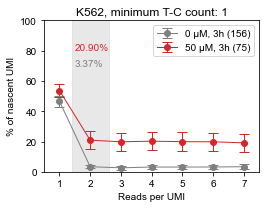

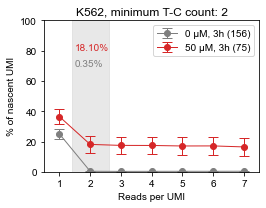

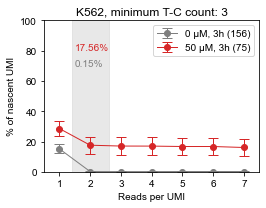

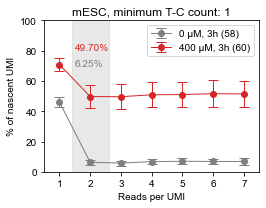

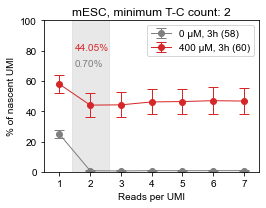

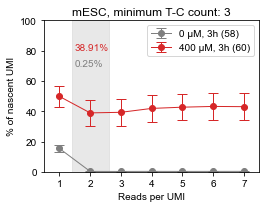

In [52]:
def get_nascent_proportion(data, cells, min_tc_count):
    max_size = 7
    rows = []
    new_cells = []
    for cell in cells:
        d = data[cell]
        rs = []
        keep = True
        for read_count in range(1, max_size + 1):
            d1 = d[(d["Size"] == read_count) & (d["T-C"] < min_tc_count)]
            d2 = d[(d["Size"] == read_count) & (d["T-C"] >= min_tc_count)]
            if len(d1) + len(d2) < 200:
                keep = False
                continue
            r = len(d2) * 100 / (len(d1) + len(d2))
            rs.append(r)
        if keep:
            new_cells.append(cell)
            rows.append(rs)
    d = pd.DataFrame(rows)
    d.columns = range(1, max_size + 1)
    d.index = new_cells
    return d

for strain in ["K562", "mESC"]:
    print("=" * 80)
    print("Strain:", strain)
    
    if strain == "K562":
        s4u = 50
        df1, df2 = d1, d2
    else:
        s4u = 400
        df1, df2 = d3, d4
    print(len(df1), len(df2))

    for min_tc_count in [1, 2, 3]:
        print("-" * 80)
        print("Min TC counts:", min_tc_count)
        cells1 = set(df1["Cell"]) & data.keys()
        cells2 = set(df2["Cell"]) & data.keys()
        print(len(cells1), len(cells2), sep="\t")
        m1 = get_nascent_proportion(data, cells1, min_tc_count)
        m2 = get_nascent_proportion(data, cells2, min_tc_count)
        print(len(m1), len(m2), sep="\t")
        means1 = m1.mean(axis=0)
        stds1 = m1.std(axis=0)
        means2 = m2.mean(axis=0)
        stds2 = m2.std(axis=0)
        xs = m1.columns
        p1, p2 = means1[2], means2[2]
        print("2 reads per UMI, nascent proportion:", p1, p2, sep="\t")
        plt.figure(figsize=(3.8, 3))
        plt.title("%s, minimum T-C count: %d" % (strain, min_tc_count))
        plt.errorbar(m1.columns, means1, yerr=stds1, marker="o", color="C7", \
                     capsize=5, lw=1, capthick=1, label="0 μM, 3h (%d)" % len(m1))
        plt.errorbar(m2.columns, means2, yerr=stds2, marker="o", color="C3", \
                     capsize=5, lw=1, capthick=1, label="%d μM, 3h (%d)" % (s4u, len(m2)))
        if True:
            plt.axvspan(2 - 0.6, 2 + 0.6, color="lightgrey", alpha=0.5)
            plt.text(2 - 0.5, 70, "%.2f%%" % p1, color="C7", ha="left")
            plt.text(2 - 0.5, 80, "%.2f%%" % p2, color="C3", ha="left")
        plt.xlim(0.5, 7.5)
        plt.ylim(0, 100)
        plt.xlabel("Reads per UMI")
        plt.ylabel("% of nascent UMI")
        plt.xticks(xs)
        plt.legend()
        plt.tight_layout()
        # plt.show()
        plt.savefig("figures/nascent_rna_proportion.%s.%dTC.pdf" % (strain, min_tc_count), dpi=300)
        # break
    # break

## 2. Nascent RNA porportion at 2TC threshold

0.36338905436008734	0.23471242376136775
99.6366109456399	0.2347124237613672
16.460659080788513	5.779637494278408
83.53934091921148	5.7796374942784094
0.7999128927603438	0.2664152301469988
99.20008710723965	0.2664152301469984
46.42072764997789	8.243870610414303
53.57927235002211	8.243870610414302


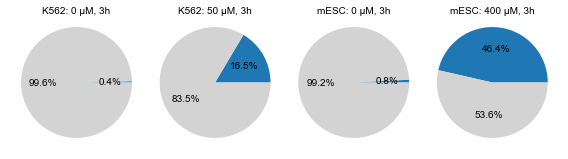

In [128]:
df_list = [d1, d2, d3, d4]
titles = ["K562: 0 μM, 3h", "K562: 50 μM, 3h", "mESC: 0 μM, 3h", "mESC: 400 μM, 3h"]

fig, axs = plt.subplots(1, 4, figsize=(8, 3), sharex=True, sharey=True, gridspec_kw={"wspace": 0})
for i, df in enumerate(df_list):
    plt.sca(axs[i])
    # plt.title(titles[i])
    vs1 = df["NascentRatio2"] * 100 # get_ratios(df)
    vs2 = [100 - v for v in vs1]
    print(np.mean(vs1), np.std(vs1), sep="\t")
    print(np.mean(vs2), np.std(vs2), sep="\t")
    plt.pie([np.mean(vs1), np.mean(vs2)], 
            colors=["C0", "lightgrey"], 
            # labels=["%.1f±%.1f%%" % (np.mean(vs1), np.std(vs1)), "%.1f±%.1f%%" % (np.mean(vs2), np.std(vs2))], labeldistance=0.2,
            autopct='%.1f%%', pctdistance=0.6, 
            wedgeprops=dict(width=1))
    plt.text(0, 1.2, titles[i], ha="center", va="bottom")
plt.tight_layout()
plt.savefig("figures/nascent_rna_proportion.pie.pdf", dpi=300)

## 3. Nascent RNA proportion at 2TC threshold for test conditions

    100uM, 200uM, 400uM, 500uM
    15min, 30min, 1h, 2h

190	0 μM, 3 h
99	50 μM, 3 h
32	50 μM, 15 min
51	50 μM, 30 min
41	50 μM, 1 h
44	50 μM, 2 h
68	0 μM, 3 h
63	50 μM, 3 h
81	0 μM, 3 h
59	50 μM, 3 h
19	100 μM, 3 h
11	200 μM, 3 h
17	400 μM, 3 h
23	500 μM, 3 h
64	0 μM, 3 h
79	50 μM, 3 h
107	400 μM, 3 h


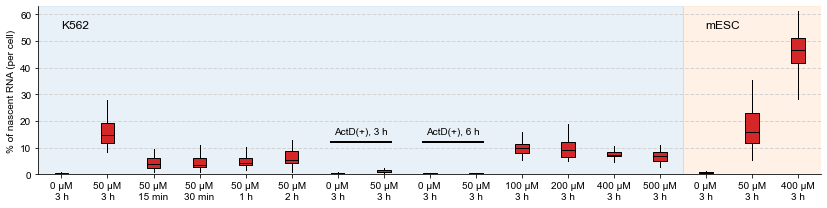

In [130]:
infos = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
infos = infos[infos["UMIs"] >= 5000]

df_list = []
ticks = []

df1 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 0) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df2 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df2 = df2[(df2["TCRatio"] > 0.008) & (df2["TCRatio"] < 0.02)]
df_list.extend([df1, df2])
ticks.extend(["0 μM\n3 h", "50 μM\n3 h"])

# time
df1 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 0.25) & (np.isnan(infos["ActD"]))]
df2 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 0.5) & (np.isnan(infos["ActD"]))]
df3 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 1) & (np.isnan(infos["ActD"]))]
df4 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 2) & (np.isnan(infos["ActD"]))]
df_list.extend([df1, df2, df3, df4])
ticks.extend(["50 μM\n15 min", "50 μM\n30 min", "50 μM\n1 h", "50 μM\n2 h"])

# actd
df1 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 0) & (infos["Time"] == 3) & (infos["ActD"] == 3)]
df2 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 3) & (infos["ActD"] == 3)]
df3 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 0) & (infos["Time"] == 3) & (infos["ActD"] == 6)]
df4 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 50) & (infos["Time"] == 3) & (infos["ActD"] == 6)]
df_list.extend([df1, df2, df3, df4])
ticks.extend(["0 μM\n3 h", "50 μM\n3 h", "0 μM\n3 h", "50 μM\n3 h"])

# concentration
df1 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 100) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df2 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 200) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df3 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 400) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df4 = infos[(infos["Strain"] == "K562") & (infos["s4U"] == 500) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df_list.extend([df1, df2, df3, df4])
ticks.extend(["100 μM\n3 h", "200 μM\n3 h", "400 μM\n3 h", "500 μM\n3 h"])

# mESC
df1 = infos[(infos["Strain"] == "mESC") & (infos["s4U"] == 0) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df2 = infos[(infos["Strain"] == "mESC") & (infos["s4U"] == 50) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df3 = infos[(infos["Strain"] == "mESC") & (infos["s4U"] == 400) & (infos["Time"] == 3) & (np.isnan(infos["ActD"]))]
df3 = df3[(df3["TCRatio"] > 0.01) & (df3["TCRatio"] < 0.03)]

df_list.extend([df1, df2, df3])
ticks.extend(["0 μM\n3 h", "50 μM\n3 h", "400 μM\n3 h"])

w = 0.3

plt.figure(figsize=(11.6, 3))
for i, df in enumerate(df_list):
    df = df[~df["NascentRatio2"].isna()]
    print(len(df), ticks[i].replace("\n", ", "), sep="\t")
    rs = df["NascentRatio2"] * 100
    plt.boxplot([rs], positions=[i], widths=w, 
                showfliers=False, showmeans=False,
                patch_artist=True, boxprops={"facecolor": "C3"},
                showcaps=False, medianprops={"color": "black"})
xs = np.arange(len(df_list))

x1, x2 = 6, 7
y = 12
plt.plot([x1 - w/2, x2 + w/2], [y, y], lw=2, color="black")
plt.text((x1 + x2)/2, y + 3, "ActD(+), 3 h", ha="center")

x1, x2 = 8, 9
y = 12
plt.plot([x1 - w/2, x2 + w/2], [y, y], lw=2, color="black")
plt.text((x1 + x2)/2, y + 3, "ActD(+), 6 h", ha="center")

# plt.axvline(13.5, lw=1, color="black")
plt.axvspan(-0.5, 13.5, color="C0", alpha=0.1)
plt.axvspan(13.5, 16.5, color="C1", alpha=0.1)

plt.text(0, 55, "K562", ha="left", size=12)
plt.text(14, 55, "mESC", ha="left", size=12)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)


plt.xticks(xs, ticks, rotation=0, ha="center")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 63)
plt.ylabel("% of nascent RNA (per cell)")
plt.grid(axis="y", lw=1, ls="--", color="lightgrey")
plt.tight_layout()
plt.savefig("figures/nascent_rna_proportion.bar.all_condition.pdf", dpi=300)

# Nascent genes (old)

In [43]:
tmp = infos[(infos["Strain"] == "K562") & (infos["Reads"] >= 100000)]
tmp = tmp[tmp["Run"] != "20221014_K562R1"]
tmp = tmp[tmp["Run"] != "20221014_K562R2"]    
ds = []
ds.append(tmp[(tmp["s4U"] == 0) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 0.25) & (np.isnan(tmp["ActD"])) & (tmp["TC"] > 0)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 0.5) & (np.isnan(tmp["ActD"])) & (tmp["TC"] > 0)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 1) & (np.isnan(tmp["ActD"])) & (tmp["TC"] > 0)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 2) & (np.isnan(tmp["ActD"])) & (tmp["TC"] > 0)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"])) & (tmp["TC"] > 0)])
print([len(d) for d in ds])
cells_list = [d["Cell"] for d in ds]

[155, 28, 49, 38, 28, 154]


In [81]:
array1 = []
array2 = []
array3 = []
for d in ds:
    vs1 = []
    vs2 = []
    vs3 = []
    for run, cell in d[["Run", "Cell"]].values:
        path = "../1_NanoNASCseq/results/nascent/quantify/%s/%s.tsv" % (run, cell)
        df = pd.read_csv(path, sep="\t", index_col=0)
        vs1.append(df["Nascent"].sum() / df["Total"].sum())
        vs2.append(len(df[df["Nascent"] > 0]))
        vs3.append(len(df[df["Total"] > 0]))
    array1.append(np.array(vs1))
    array2.append(np.array(vs2))
    array3.append(np.array(vs3))

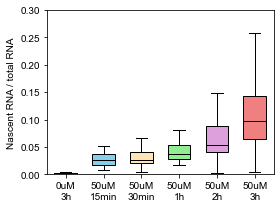

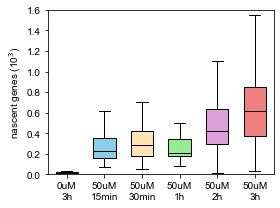

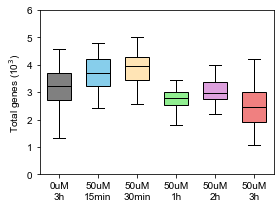

In [84]:
# colors = ["grey", "bisque", "lightcoral", "firebrick", "brown", "maroon", "red"]
colors = ["grey", "skyblue", "moccasin", "lightgreen", "plum", "lightcoral", "C5"]

plt.figure(figsize=(4, 3))
for i, vs in enumerate(array1):
    plt.boxplot([vs], positions=[i], widths=0.6, medianprops={"color": "black"}, showcaps=True, 
                showfliers=False, showmeans=False, patch_artist=True, boxprops={"facecolor": colors[i]})
plt.ylim(0, 0.3)
plt.xticks(np.arange(len(ds)), 
           ["0uM\n3h", "50uM\n15min", "50uM\n30min", "50uM\n1h", "50uM\n2h", "50uM\n3h"])
plt.ylabel("Nascent RNA / total RNA")
plt.tight_layout()
plt.savefig(outdir + "/nascent_rna_proportion.time.pdf", dpi=30)

plt.figure(figsize=(4, 3))
for i, vs in enumerate(array2):
    plt.boxplot([vs/1000], positions=[i], widths=0.6, medianprops={"color": "black"}, showcaps=True, 
                showfliers=False, showmeans=False, patch_artist=True, boxprops={"facecolor": colors[i]})
    # xs = np.random.random(len(vs)) * 0.4 - 0.2 + i
    # plt.scatter(xs, vs, marker="o", s=10)
plt.ylim(0, 1.6)
plt.xticks(np.arange(len(ds)), 
           ["0uM\n3h", "50uM\n15min", "50uM\n30min", "50uM\n1h", "50uM\n2h", "50uM\n3h"])
plt.ylabel("nascent genes (10$^3$)")
plt.tight_layout()
plt.savefig(outdir + "/nascent_gene_number.time.pdf", dpi=30)

plt.figure(figsize=(4, 3))
for i, vs in enumerate(array3):
    plt.boxplot([vs/1000], positions=[i], widths=0.6, medianprops={"color": "black"}, showcaps=True, 
                showfliers=False, showmeans=False, patch_artist=True, boxprops={"facecolor": colors[i]})
    # xs = np.random.random(len(vs)) * 0.4 - 0.2 + i
    # plt.scatter(xs, vs, marker="o", s=10)
plt.ylim(0, 6)
plt.xticks(np.arange(len(ds)), 
           ["0uM\n3h", "50uM\n15min", "50uM\n30min", "50uM\n1h", "50uM\n2h", "50uM\n3h"])
plt.ylabel("Total genes (10$^3$)")
plt.tight_layout()
plt.savefig(outdir + "/total_gene_number.time.pdf", dpi=30)

# Detected nascent genes

0	190	13.947368421052632	12.0
1	105	789.9619047619047	707.0
2	64	43.65625	38.0
3	110	1659.990909090909	1589.0


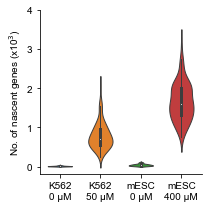

In [119]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[d["UMIs"] >= 5000]
df1 = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
df2 = d[(d["Strain"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna())]
df2 = df2[df2["TCRatio"] > 0.008]
df3 = d[(d["Strain"] == "mESC") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
df4 = d[(d["Strain"] == "mESC") & (d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna())]
df4 = df4[df4["TCRatio"] > 0.008]
df_list = [df1, df2, df3, df4]

rows = []
for i, df in enumerate(df_list):
    vs = df["Genes2[Nascent2]"]
    print(i, len(df), np.mean(vs), np.median(vs), sep="\t")
    for v in vs:
        rows.append([i, v/1e3])
        
m = pd.DataFrame(rows)
m.columns = ["Type", "Genes"]
xs = np.arange(4)

plt.figure(figsize=(3, 3))
sns.violinplot(data=m, x="Type", y="Genes", scale="width", width=0.6, linewidth=1)
plt.xlim(-0.5, 3.5)
plt.ylim(-0.2, 4)
plt.xticks(xs, ["K562\n0 μM", "K562\n50 μM", "mESC\n0 μM", "mESC\n400 μM"])
plt.xlabel(None)
plt.ylabel("No. of nascent genes (x10$^3$)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/nascent_genes.pdf", dpi=300)

# Profiling of T-C count and ratio at read level

In [134]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[d["UMIs"] >= 5000]

df1 = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
df2 = d[(d["Strain"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna())]
df2 = df2[df2["TCRatio"] > 0.008]

df1 = df1.head(10)
df2 = df2.head(10)

df_list = [df1, df2]

In [136]:
def stat_tc(bamfile, f_tsv=None):
    umis = None
    if f_tsv:
        tmp = pd.read_csv(f_tsv, sep="\t", header=0, index_col=0)
        umis = set(tmp[(tmp["Size"] >= 2) & (tmp["T-C"] >= 1)].index)
    
    rows = []
    with pysam.AlignmentFile(bamfile) as f:
        for s in f:
            #if s.is_duplicate:
            #    continue
            
            if umis is not None and s.get_tag("CN") not in umis:
                continue
    
            counter1 = defaultdict(int)
            for item in s.get_tag("RC").split(";"):
                if item == "":
                    continue
                k, v = item.split(",")
                counter1[k] = int(v)

            counter2 = defaultdict(int)
            for item in s.get_tag("CE").split(";"):
                if item == "":
                    continue
                tmp = item.split(",")
                ref, alt = tmp[1], tmp[2]
                counter2[(ref, alt)] += 1

            if s.is_forward:
                t = counter1["T"]
                tc = counter2[("T", "C")]
            else:
                t = counter1["A"]
                tc = counter2[("A", "G")]
            rows.append([t, tc])
    # print("Finished %s" % bamfile)
    return rows

data = dict()

pool = mpl.Pool(24)

for run, cell in df1[["Run", "Cell"]].values:
    bamfile = "../../1_NanoNASCseq/results/mismatch/events/%s/%s.bam" % (run, cell)
    data[cell] = pool.apply_async(stat_tc, (bamfile,))
    
for run,cell in df2[["Run", "Cell"]].values:
    bamfile = "../../1_NanoNASCseq/results/mismatch/events/%s/%s.bam" % (run, cell)
    tsvfile = "../../1_NanoNASCseq/results/mismatch/ratio_consensus/%s/%s.events.tsv" % (run, cell)
    data[cell] = pool.apply_async(stat_tc, (bamfile, tsvfile))

pool.close()
pool.join()

for cell in data:
    data[cell] = data[cell].get()

--------------------------------------------------------------------------------
Condition	No. of T-C	Mean	Std
0	0	62.29444813598569	2.63748548939108
0	1	23.178420504579968	0.8630266855786348
0	2	7.989999738807008	0.7585320562865886
0	3	3.1728157053015904	0.4530320903191474
0	4	1.4453702161284978	0.2652081292366681
0	5	0.7393670307924379	0.14199823561124938
0	6	0.4271507059512743	0.0844723660345047
0	7	0.2500227627878858	0.07079396838887965
0	8	0.160317206663978	0.038951256788857386
0	9	0.10011699565888392	0.036160651578645536
0	10	0.07289055405287312	0.021495563654591956
--------------------------------------------------------------------------------
Condition	No. of T-C	Mean	Std
1	0	0.39328471138634	0.1067969543661698
1	1	15.730568637487801	3.6464577047287845
1	2	5.788197875693333	1.772633333198584
1	3	2.7569061016526866	0.7844568847882593
1	4	2.2325459408869466	0.32831949686045214
1	5	2.00959910296145	0.42464635686324304
1	6	2.0697192144147003	0.5712312764430466
1	7	2.12441605259692

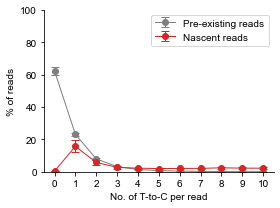

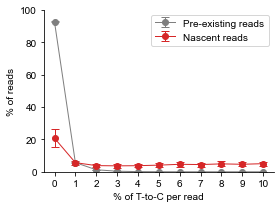

In [159]:
max_tc = 10
max_ratio = 10
w = 0.5
labels = ["Pre-existing reads", "Nascent reads"]
colors = ["C7", "C3"]

plt.figure(figsize=(4, 3))
for i, df in enumerate(df_list):
    rows = []
    for cell in df["Cell"]:
        counter = Counter([row[1] for row in data[cell]])
        vs = [counter[i] for i in range(max_tc + 1)]
        rows.append(np.array(vs) / sum(counter.values()))
    m = pd.DataFrame(rows) * 100
    ys = m.mean(axis=0)
    yerr = m.std(axis=0)
    xs = np.arange(len(ys))
    print("-" * 80)
    print("Condition\tNo. of T-C\tMean\tStd")
    for x, y, y1 in zip(xs, ys, yerr):
        print(i, x, y, y1, sep="\t")
    plt.errorbar(xs, ys, yerr=yerr, label=labels[i], capsize=4, lw=1, marker="o", color=colors[i])
plt.xticks(xs)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)
plt.xlabel("No. of T-to-C per read")
plt.ylabel("% of reads")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.tight_layout()
plt.savefig("figures/stat_of_tc_ratio.pdf", dpi=300)

plt.figure(figsize=(4, 3))
for i, df in enumerate(df_list):
    rows = []
    for cell in df["Cell"]:
        counter = Counter([int(row[1] * 100 / row[0]) for row in data[cell]])
        vs = [counter[i] for i in range(max_ratio + 1)]
        rows.append(np.array(vs) / sum(counter.values()))
    m = pd.DataFrame(rows) * 100
    ys = m.mean(axis=0)
    yerr = m.std(axis=0)
    xs = np.arange(len(ys))
    print("-" * 80)
    print("Condition\t% of T-C\tMean\tStd")
    for x, y, y1 in zip(xs, ys, yerr):
        print(i, x, y, y1, sep="\t")
    plt.errorbar(xs, ys, yerr=yerr, label=labels[i], capsize=4, lw=1, marker="o", color=colors[i])
plt.xticks(xs)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)
plt.xlabel("% of T-to-C per read")
plt.ylabel("% of reads")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.tight_layout()
plt.savefig("figures/stat_of_tc_count.pdf", dpi=300)